##                      WORKSHOP 3: ORGANIC DATA GENERATION III
In this third workshop, we will generate new data from networks and clusters.   

### Task 1: Read data and set thresholds
- Firstly, we will read in the two data files we saved last week: employees_df and similarity_df.
- Secondly, we will create a measure "very_similar" which is half a standard deviation above the mean of all similarity values. Before we create this measure, let's think about why it is a good for determining similar pairs of individuals?

<hr>
_Hint_: The simplest way to create this measure is to first create a list, all_similarity_scores which contains all the similarity scores in similarity_df, then calculate the threshold like this: `very_similar = np.mean(all_sim_scores)+0.5*np.std(all_sim_scores)`. Note that we will need to exclude similarity scores of 1 which occured when we measured a person's similarity to him/herself. 




In [21]:
import pandas as pd
import numpy as np
from itertools import chain


# Reading in Pickle Files
employees_df = pd.read_pickle('./Data/employees_df.pkl')
similarity_df = pd.read_pickle('./Data/similarity_df.pkl')


all_sim_scores=list(chain.from_iterable(list(similarity_df['similarity_vector'])))
very_similar = np.mean(all_sim_scores)+0.5*np.std(all_sim_scores) 
print(very_similar)

0.118556592832


### Task 2: Generating similarity networks

We will use the `networkx` package to generate a network. The network will have an edge for each employee (`person_id`) and an edge between to people if the similarity score between them is greater than or equal to the value `very_similar` which we generated in the first task. 

The following steps will help generate the network:
>- create an empty graph. 
>- add a node to the graph for every person_id
>- loop through person_id (in similarity_df) to extract their similarity vector. Then, loop through the similarity_vector, adding a value of 1 wherever the value is greater than or equal to `very_similar`. Recall that the order of people in similarity_vector is the same as person_id. For example, similarity_df['similarity_vector'][0][10] will show the similarity score between 'k.m.abadir' and 'p.cosgrove'  

The following link has a quick tutorial on how to generate a network:
https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html


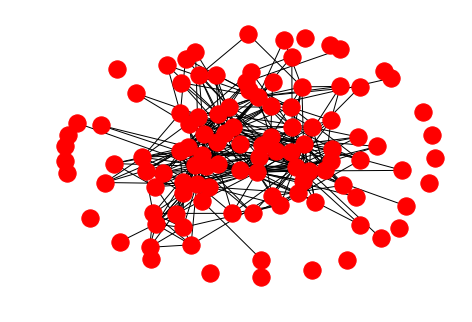

416


In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# creating an empty networkx graph
G=nx.Graph()

# setting each person_id as a node that will go into the graph
nodes = list(similarity_df['person_id'])

# adding nodes to the graph
for node in nodes:
    G.add_node(node)

# adding edges between nodes (pairs of employees) with similarity score >= very similar
# adding edges between nodes (pairs of employees) with similarity score >= very similar
cnt = 0
for i in range(len(nodes)):
    # getting the similarity vector of person_id[i]
    simvec = similarity_df['similarity_vector'][i]
    for j in range(len(nodes)):
        if i != j:
            # getting similarity score to person j
            simscore = simvec[j]
            # adding edge from nodes[i] to nodes[j] if simscore >= very_similar
            if simscore>=very_similar:
                G.add_edge(nodes[i],nodes[j])
                cnt+=1
# plotting graph
pos=nx.spring_layout(G)
nx.draw(G, pos)
plt.show()
print(len(G.edges()))

### Task 3: Deriving new variables from networks
Now that we have created a network, we will generate two metrics degree_centrality and betweenness_centrality that are derived from the network. Degree centrality measures the number of ties a person has and, in a social network, reflects the amount of information that a person accesses. Betweenness centrality is a measure of the extent to which a person is connected to unconnected individuals, and reflects the amount of information that the person can control. We will add these two variables as columns in employees_df, and we will name them: `betweenness_centrality` and `degree_centrality`.

The network we generated is not a social network, so can the centrality measures be defined in the same way?




In [23]:
# Calculate betweenness_centrality and degree_centrality for every node in the network created in Task 2.
bet_centrality = nx.betweenness_centrality(G)
deg_centrality = nx.degree_centrality(G)

# Initialize betweenness_centrality and degree_centrality
betweenness_centrality=[]
degree_centrality=[]

# Loop through employees_df, and populate the two new columns
for p in employees_df.person_id:
    betweenness_centrality.append(bet_centrality[p])
    degree_centrality.append(deg_centrality[p])

# Add the centrality columns to employees_df    
employees_df['betweenness_centrality'] =  betweenness_centrality
employees_df['degree_centrality'] =  degree_centrality


### Task 4: Centrality and Seniority
Is there a relationship between centrality and seniority? In this task, we will examine the correlation between them, but will first have to preprocess the "title_clean" column, which contains the seniority information. 

If we print the unique values in that coloumn `list(np.unique(employees_df['title_clean']))`, we will get the following list:

`['Assistant Professor', 'Associate Professor', 'Principal Teaching Fellow', 'Professor', 'Research Associate','Senior Teaching Fellow']`

Let's create a new column `seniority` that assigns a numerical value that reflects seniority. 
>- 1 for Research Associate
>- 2 for Assistant Professor and Senior Teaching Fellow
>- 3 for Associate Professor and Principal Teaching Fellow
>- 4 for Professor

Let's also create a second column `tenure_track` which takes a value of 1 if a person is a professor at any level (assistant, associate, professor) and a value of 0 otherwise. 

Once we've created the measures, let's examine the correlation between degree centrality and tenure for professors (i.e. `tenure_track` = 1) versus teaching fellows (`tenure_track = 0`). What do the results suggest?


In [24]:
# Initialize seniority and tenure_track columns
seniority = []
tenure_track = []

# Loop through 'title_clean' and populate the seniority and tenure_track lists
for t in employees_df['title_clean']:
    # assigning values for seniority
    if t in ['Research Associate']:
        seniority.append(1)
    elif t in ['Assistant Professor', 'Senior Teaching Fellow']:
        seniority.append(2)
    elif t in ['Associate Professor', 'Principal Teaching Fellow']: 
        seniority.append(3)
    else: 
        seniority.append(4)
    # assigning values for tenure track    
    if t in ['Assistant Professor', 'Associate Professor', 'Professor']: 
        tenure_track.append(1)
    else:
        tenure_track.append(0)
        
# adding to DataFrame
employees_df['seniority']= seniority
employees_df['tenure_track'] = tenure_track


# Checking the correlation coefficient between 
seniority_tenure=[seniority[x] for x in range(len(tenure_track)) if tenure_track[x]==1]
degree_tenure=[degree_centrality[x] for x in range(len(tenure_track)) if tenure_track[x]==1]
between_tenure=[betweenness_centrality[x] for x in range(len(tenure_track)) if tenure_track[x]==1]
r = np.corrcoef(seniority_tenure, degree_tenure) 
r1= r[0][1]
r = np.corrcoef(seniority_tenure, between_tenure) 
r3= r[0][1]


seniority_nontenure=[seniority[x] for x in range(len(tenure_track)) if tenure_track[x]==0]
degree_nontenure=[degree_centrality[x] for x in range(len(tenure_track)) if tenure_track[x]==0]
between_nontenure=[betweenness_centrality[x] for x in range(len(tenure_track)) if tenure_track[x]==0]
r = np.corrcoef(seniority_nontenure, degree_nontenure) 
r2= r[0][1]
r = np.corrcoef(seniority_nontenure, between_nontenure) 
r4= r[0][1]


s1= 'For professors, the correlation between degree centrality and seniority is ' + str(np.round(r1,3)) + '. '
s2= 'For teaching fellows, the correlation between degree centrality and seniority is ' + str(np.round(r2,3)) +'.' 

print(s1+s2)



For professors, the correlation between degree centrality and seniority is -0.36. For teaching fellows, the correlation between degree centrality and seniority is -0.323.


In [25]:
s1= 'For professors, the correlation between betweenness centrality and seniority is ' + str(np.round(r3,3)) + '. '
s2= 'For teaching fellows, the correlation between betweenness centrality and seniority is ' + str(np.round(r4,3)) +'.' 

print(s1+s2)

For professors, the correlation between betweenness centrality and seniority is -0.246. For teaching fellows, the correlation between betweenness centrality and seniority is 0.098.


### Task 5: Clustering to group employees

In this task, we will create clusters (using k-means clustering) from the similarity network that we've generated in Task 2. 
One difficulty with k-means clustering is knowing the right number of clusters. There are a number of ways to do this. I used the "gap statistic" and found the optimal number of clusters to be 5. For more on the gap statistic: https://www.chartyn.com/code-7-a-candid-k-for-k-means-clustering


<hr>


In [26]:
from sklearn import cluster

# Converting network to adjacency matrix. We'll run kmeans on the adjacency matrix.  
A = nx.adjacency_matrix(G)

# Calling k-means clustering
kmeans = cluster.KMeans(n_clusters=5, n_init=200)
kmeans.fit(A)
cluster_label = kmeans.predict(A)

# Adding cluster_number to each employee
employees_df['cluster_label'] = cluster_label



### Task 6: Acquired diversity in departments and clusters
In this task, we will compare tenure diversity in departments and cluster. Let's define diversity as 1- Herfindahl index of the positions (seniority) of employees. To do this, let's begin by creating a function for the Herfindahl index. We will reuse this function later for inherent diversity. 

The herfindahl index is calculated by taking the proportion of each item in the list, squaring the proportions, then summing.   
Its easiest to do this in the following steps:
     -- find the unique items in the list.
     -- for each unique item, measure proportion as the occurences of item/total items in list
     -- sum all proportions

Herfindahl = p1^2 + p2^2 + p3^2 + ... + pn^2 


Once we've defined the herfindahl index, let's calculate the diveristy of each department and each cluster, using the values in 'employees_df['seniority']. Let's save these in the following dictionaries `dept_acquired_diversity`, `clust_acquired_diversity`, where keys are departmental names and cluster labels respectively.


In [27]:
def herfindahl(input_list):
    unique_vals = list(np.unique(input_list))
    prop = []
    for val in unique_vals:
        tmp = input_list.count(val)/float(len(input_list))
        prop.append(tmp)
    sq_prop = [x**2 for x in prop]
    return sum(sq_prop)


# getting unique departments
depts = list(np.unique(employees_df['department']))

dept_acquired_diversity={}
for dept in depts:
    input_list =[employees_df['seniority'][i] for i, x in enumerate(employees_df['department']) if x == dept]
    dept_acquired_diversity[dept] = 1-herfindahl(input_list)

clusters = np.unique(cluster_label)
clust_acquired_diversity={}
for c in clusters:
    input_list =[employees_df['seniority'][i] for i, x in enumerate(employees_df['cluster_label']) if x == c]
    clust_acquired_diversity[c] = 1-herfindahl(input_list)


    



### Task 7: Inherent Diversity in Departments and Cluster
In workshop 1, we created two variables (`gender` and `ethnicity`) from which we can generate our inherent diversity measure. we will create 4 additional dictionaries: dept_gender_diversity={}, dept_ethnic_diversity={}, clust_gender_diversity={}
clust_ethnic_diversity={}.


In [28]:
dept_gender_diversity={}
dept_ethnic_diversity={}
for dept in depts:
    input_list1 =[employees_df['gender'][i] for i, x in enumerate(employees_df['department']) if x == dept]
    input_list2 =[employees_df['ethnicity'][i] for i, x in enumerate(employees_df['department']) if x == dept]
    dept_gender_diversity[dept] = 1-herfindahl(input_list1)
    dept_ethnic_diversity[dept] = 1-herfindahl(input_list2)

clust_gender_diversity={}
clust_ethnic_diversity={}
clusters = np.unique(cluster_label)
for c in clusters:
    input_list1 =[employees_df['gender'][i] for i, x in enumerate(employees_df['cluster_label']) if x == c]
    input_list2 =[employees_df['ethnicity'][i] for i, x in enumerate(employees_df['cluster_label']) if x == c]
    clust_gender_diversity[c] = 1-herfindahl(input_list1)
    clust_ethnic_diversity[c] = 1-herfindahl(input_list2)



### Task 8: Adding Department and Cluster Data to `employees_df`
In this task, we will loop through each emplpoyee in employees_df and add the following variables:
- `department_size`: The size (number of people) of the person's department. 
- `department_tenure_diverity`: is the tenure diversity of the person's department
- `department_gender_diverity`: is the gender diversity of the person's department
- `department_ethnic_diverity`: is the ethnic diversity of the person's department
- `cluster_size`: The size (number of people) in the person's cluster
- `cluster_tenure_diverity`: is the tenure diversity of the person's cluster
- `cluster_gender_diverity`: is the gender diversity of the person's cluster
- `cluster_ethnic_diverity`: is the cluster diversity of the person's cluster

In [29]:
department_size=[]
department_tenure_diversity=[]
department_gender_diversity=[]
department_ethnic_diversity =[]
cluster_size = []
cluster_tenure_diversity=[]
cluster_gender_diversity=[]
cluster_ethnic_diversity =[]

# looping through each row of person_id
for i in range(len(employees_df['person_id'])):
    this_dept = employees_df['department'][i]
    this_cluster = employees_df['cluster_label'][i]
    department_size.append(len([x for x in employees_df['department'] if x== this_dept]))
    cluster_size.append(len([x for x in employees_df['cluster_label'] if x== this_cluster]))
    department_tenure_diversity.append(dept_acquired_diversity[this_dept])
    department_gender_diversity.append(dept_gender_diversity[this_dept])
    department_ethnic_diversity.append(dept_ethnic_diversity[this_dept])
    cluster_tenure_diversity.append(clust_acquired_diversity[this_cluster])
    cluster_gender_diversity.append(clust_gender_diversity[this_cluster])
    cluster_ethnic_diversity.append(clust_ethnic_diversity[this_cluster])
    

employees_df['department_size']= department_size
employees_df['cluster_size'] = this_cluster
employees_df['department_tenure_diversity'] = department_tenure_diversity
employees_df['department_gender_diversity'] = department_gender_diversity
employees_df['department_ethnic_diversity'] = department_ethnic_diversity
employees_df['cluster_tenure_diversity'] = cluster_tenure_diversity
employees_df['cluster_gender_diversity'] = cluster_gender_diversity
employees_df['cluster_ethnic_diversity'] = cluster_ethnic_diversity


### _[Optional]_ Task 9a:Tabulate the diversity results

Create two tables to display the diversity results: a table for the tenure, ethnic, and gender diversity across departments, and another for the same diversity scores across clusters. 



In [30]:
department_diversity_df = employees_df[['department', 'department_tenure_diversity',
                                        'department_ethnic_diversity', 'department_gender_diversity']]
display(department_diversity_df.groupby('department').mean().style)

,department_tenure_diversity,department_ethnic_diversity,department_gender_diversity
department,,,
Department of Finance,0.669388,0.364082,0.507755
Department of Innovation and Entrepreneurship,0.730159,0.172336,0.653061
Department of Management,0.742798,0.336763,0.575446


In [31]:
cluster_diversity_df = employees_df[['cluster_label', 'cluster_tenure_diversity',
                                     'cluster_ethnic_diversity', 'cluster_gender_diversity']]
display(cluster_diversity_df.groupby('cluster_label').mean().style)

,cluster_tenure_diversity,cluster_ethnic_diversity,cluster_gender_diversity
cluster_label,,,
0,0.495868,0.46281,0.595041
1,0.59375,0,0.375
2,0.717496,0.31842,0.564587
3,0.666667,0.277778,0.444444
4,0.671875,0.304688,0.460938


### Task 9b _Optional_: Visualize employees_df using a correlation heatmap

Firstly, lets look at the correlation coefficient 
Generate a correlation heatmap for the following columns in employees_df:  'colleagues',

 'adjective_positivity',
 'dept_similarity',
 'outdept_similarity',
 'betweenness_centrality',
 'degree_centrality',
 'seniority',
 'tenure_track',
 'department_size',
 'cluster_size',
 'department_tenure_diversity',
 'department_gender_diversity',
 'department_ethnic_diversity',
 'cluster_tenure_diversity',
 'cluster_gender_diversity',
 'cluster_ethnic_diversity']
 

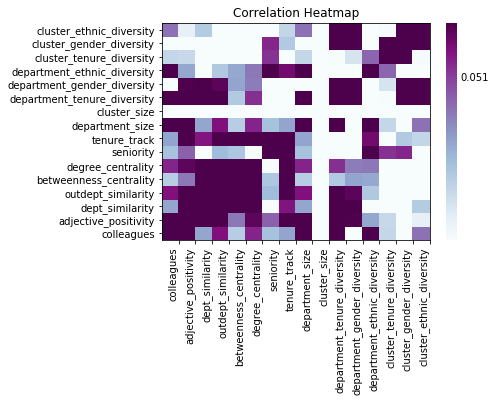

In [32]:
corr_columns = ['colleagues', 'adjective_positivity', 'dept_similarity', 'outdept_similarity', 'betweenness_centrality', 
                'degree_centrality', 'seniority', 'tenure_track', 'department_size', 'cluster_size', 
                'department_tenure_diversity', 'department_gender_diversity', 'department_ethnic_diversity', 
                'cluster_tenure_diversity', 'cluster_gender_diversity', 'cluster_ethnic_diversity']

corr_df = employees_df[corr_columns].corr()

#Plotting heatmap
import copy
cmap = copy.deepcopy(plt.cm.get_cmap('BuPu'))
cmap.set_bad('#cccccc')

plt.pcolormesh(corr_df, cmap=cmap)
yticks = [0.5 + i for i in list(range(len(corr_columns)))]
xticks = [0.5 + i for i in yticks]
plt.xticks(xticks, corr_columns, ha='right', rotation='vertical')
plt.yticks(yticks, corr_columns)


#Plotting colobar
cbar_min = np.nanmin(corr_df)
cbar_max = np.nanmax(corr_df)
cbar_mid = (cbar_max + cbar_min) / 2
cbar_ticks = [cbar_min, cbar_mid, cbar_max]

cbar = plt.colorbar()
cbar.outline.set_linewidth(0)
cbar.set_ticks(cbar_ticks)
cbar.ax.tick_params(length=0, labelsize=10)

plt.title('Correlation Heatmap')
plt.show()

### Task 9c _Optional_: Visualize employees_df using a multivariate heatmap
Generate a multivariate heatmap to explore how the following columns vary across the three departments:
    
'colleagues', 'adjective_positivity', 'dept_similarity', 'outdept_similarity', 'betweenness_centrality', 'degree_centrality',
'department_size','cluster_size', 'department_tenure_diversity', 'department_gender_diversity', 'department_ethnic_diversity', 'cluster_tenure_diversity', 'cluster_gender_diversity', 'cluster_ethnic_diversity'

I will use a single colourmap applied to all rows. 


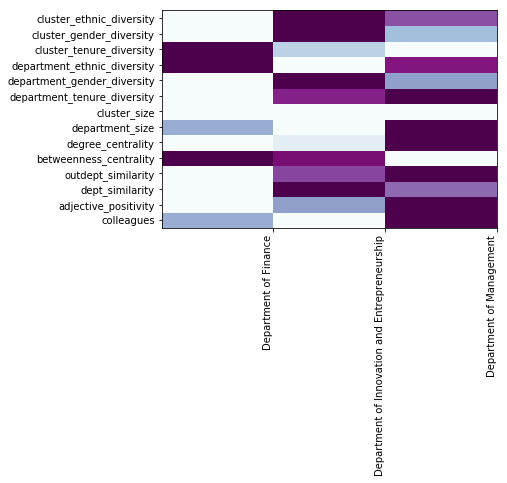

In [33]:
# CODE GOES HERE
numerical_columns = ['colleagues', 'adjective_positivity', 'dept_similarity', 'outdept_similarity', 'betweenness_centrality',
                     'degree_centrality', 'department_size', 'cluster_size', 'department_tenure_diversity', 
                     'department_gender_diversity', 'department_ethnic_diversity', 'cluster_tenure_diversity', 
                     'cluster_gender_diversity', 'cluster_ethnic_diversity']
departments = sorted(employees_df['department'].unique())
values_list = []
for column in numerical_columns:
    #groupby does the sorting of key_column by default
    mean_values = employees_df[[column, 'department']].groupby('department')[column].mean()
    values_list.append(mean_values)

#Plotting heatmap
base_mask = np.ones(shape=(len(values_list), len(values_list[0])))

for i, values in enumerate(values_list):
    i_mask = base_mask.copy()
    i_mask[i] = np.zeros(shape=(1, len(values_list[0])))   
    masked_values = np.ma.masked_array(values_list, i_mask)
    plt.pcolormesh(masked_values, cmap='BuPu')
    

yticks = [0.5 + i for i in list(range(len(numerical_columns)))]
xticks = [1 + i for i in list(range(len(departments)))]
plt.xticks(xticks, departments, ha='right', rotation = 'vertical')
plt.yticks(yticks, numerical_columns)

plt.show()

### TASK 10: Saving our new data
Our employees_df has even more rows now. Let's save it using `employees_df.to_pickle` as we did last time. 


In [34]:
# Saving employees_df
employees_df.to_pickle('./Data/employees_df.pkl')